In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


#### Reading data

In [2]:
# Read data
profile = pd.read_csv('data_treated/profile.csv')

profile.head()

,gender,age,id,became_member_on,income,user_id
0,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,0
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1
2,NaN,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,2
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,3
4,NaN,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,4


#### Filling the NaN and Feature Engineering

In the database there are some users empty values.  

Observing the data, it is noted that users who are not registrant such information such as genre, age and income.The only information it appears is when the user became a member.

In [3]:
# Observing users without some data
profile.loc[pd.isna(profile['gender'])].head()

,gender,age,id,became_member_on,income,user_id
0,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,0
2,NaN,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,2
4,NaN,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,4
6,NaN,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN,6
7,NaN,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN,7


In [4]:
# Number of users without some data
profile.loc[pd.isna(profile.gender)].shape[0] / profile.shape[0]

0.12794117647058822

12% of total users has no data for gender, age and income

**Filling NaNs**

**Income**  

For the age and income variables, it is necessary to analyze the distribution of values

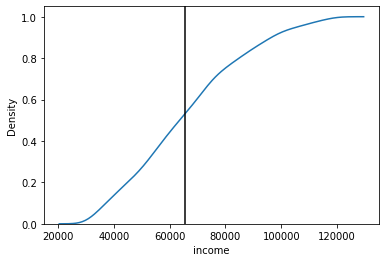

Mean income: 65404.9915682968
Median income: 64000.0


In [5]:
# Distribuition of income
sns.kdeplot(data=profile, x='income', cumulative=True)
plt.axvline(x=profile["income"].mean(), color='black')
plt.show()

print(f'Mean income: {profile["income"].mean()}')
print(f'Median income: {profile["income"].median()}')

65 thousand is the average and 64 thousand the median, which shows that 50% of the values are close to that value.  
Thus, assigning the median to the missing values will not change the distributions significantly.

In [6]:
# Fill NaN with median
profile['income'] = profile['income'].fillna(profile.income.median())

profile.head()

,gender,age,id,became_member_on,income,user_id
0,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,64000.0,0
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1
2,NaN,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,64000.0,2
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,3
4,NaN,118,a03223e636434f42ac4c3df47e8bac43,20170804,64000.0,4


**Age**

For the values of 118 in the age field, it can disrupt in the analysis.Thus, for these values, the median of the ages as a substitute will also be used.

In [7]:
# Fill 118 values with meadian, without this extreme value
profile.loc[profile.age == 118, 'age'] = profile.loc[profile.age != 118, 'age'].median()

profile.head()

,gender,age,id,became_member_on,income,user_id
0,NaN,55,68be06ca386d4c31939f3a4f0e3dd783,20170212,64000.0,0
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1
2,NaN,55,38fe809add3b4fcf9315a9694bb96ff5,20180712,64000.0,2
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,3
4,NaN,55,a03223e636434f42ac4c3df47e8bac43,20170804,64000.0,4


**Gender**  

For gender data, the voids are replaced for Not Informed.  
For application in models, this category could be treated separately later

In [8]:
# Replace NaN gender with NI (not informed)
profile['gender'] = profile['gender'].fillna('NI')

profile.head()

,gender,age,id,became_member_on,income,user_id
0,NI,55,68be06ca386d4c31939f3a4f0e3dd783,20170212,64000.0,0
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1
2,NI,55,38fe809add3b4fcf9315a9694bb96ff5,20180712,64000.0,2
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,3
4,NI,55,a03223e636434f42ac4c3df47e8bac43,20170804,64000.0,4


**Feature Engineering**

To create one more feature for users, the time they are member, in relation to the latest user, since the date of collecting the data is not known.  

It is worth mentioning that even for users without information, this data is present at the dataset

In [9]:
# Convert to datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
# Get the newest user in data
most_recent_mem_data = profile['became_member_on'].max()
# Creating a extra column to put number of years compared with newest
profile['rela_member_years'] = ((most_recent_mem_data - profile['became_member_on']).dt.days / 365).round(2)

profile.head()

,gender,age,id,became_member_on,income,user_id,rela_member_years
0,NI,55,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,64000.0,0,1.45
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,1.03
2,NI,55,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,64000.0,2,0.04
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,3,1.21
4,NI,55,a03223e636434f42ac4c3df47e8bac43,2017-08-04,64000.0,4,0.98


#### Clustiring the users

There are four fields that define information about users: age, income, time as a member and gender.

Because they are many possible groups formable with that number of columns, we can not use the natural groups.

To identify user groups within all, it is used non-supervised method of machine learning.
The technique to be used here is Clustering by K-Means

In [10]:
# Preparing dataset for clustering
profile_cluster_df = profile[['age', 'income', 'rela_member_years', 'gender']]

profile_cluster_df.head()

,age,income,rela_member_years,gender
0,55,64000.0,1.45,NI
1,55,112000.0,1.03,F
2,55,64000.0,0.04,NI
3,75,100000.0,1.21,F
4,55,64000.0,0.98,NI


In [11]:
# Gender dummy variable
profile_cluster_df = pd.get_dummies(profile_cluster_df, columns=['gender'])

# Standarlize continuous variable
scaler = StandardScaler()
standardized = scaler.fit_transform(profile_cluster_df[['age', 
    'income', 'rela_member_years']]
    )

profile_cluster_df.loc[:, ['age', 'income', 'rela_member_years']] = standardized
    
profile_cluster_df.head()

,age,income,rela_member_years,gender_F,gender_M,gender_NI,gender_O
0,0.032578,-0.060733,0.028695,0,0,1,0
1,0.032578,2.318549,-0.344099,1,0,0,0
2,0.032578,-0.060733,-1.222830,0,0,1,0
3,1.264535,1.723728,-0.184330,1,0,0,0
4,0.032578,-0.060733,-0.388480,0,0,1,0


**PCA**

The 7 variables visualized above can be reduced in two to facilitate the clustering of the data.

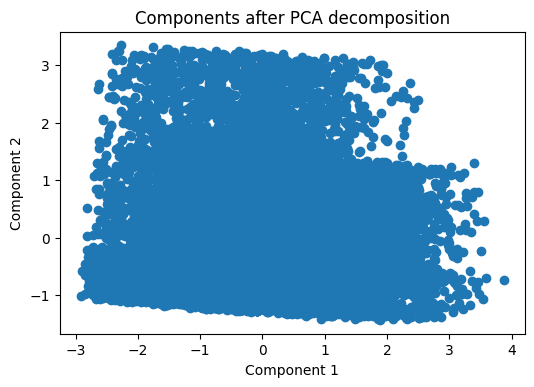

In [12]:
# Using PCA to cluster

# PCA with 2 components
pca = PCA(n_components=2, random_state=256) # fixed state to reproducibility
components = pca.fit_transform(profile_cluster_df)

# Visualization of components
plt.figure(dpi=100)
plt.scatter(components[:,0],components[:,1])
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Components after PCA decomposition')
plt.show()

**Clustering**

To identify groups between the data, the k-means method is used, In which data is grouped by shared averages (centroids)

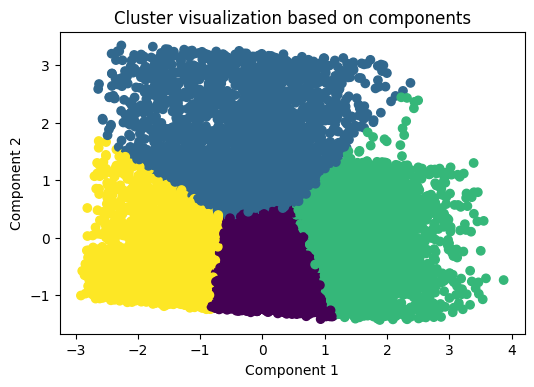

In [13]:
# Using kmeans to cluster via components

# Cluster in 4 groups
kmeans = KMeans(n_clusters=4, random_state=256) # fixed state to reproducibility
clusters = kmeans.fit_predict(components)

# Visualizing
plt.figure(dpi=100)
plt.scatter(components[:,0],components[:,1], c=clusters)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Cluster visualization based on components')
plt.show()

In [14]:
# Returning the clusters to the original dataset
profile['user_cluster'] = clusters

profile.head()

,gender,age,id,became_member_on,income,user_id,rela_member_years,user_cluster
0,NI,55,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,64000.0,0,1.45,0
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,1.03,2
2,NI,55,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,64000.0,2,0.04,0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,3,1.21,2
4,NI,55,a03223e636434f42ac4c3df47e8bac43,2017-08-04,64000.0,4,0.98,0


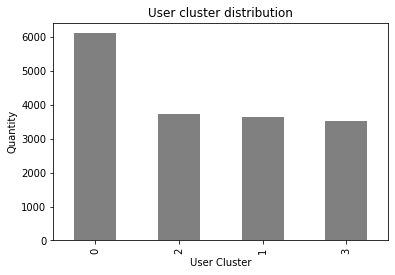

In [15]:
# Analyzing Statistics of Clusters

profile['user_cluster'].value_counts().plot.bar(color='gray')
plt.title('User cluster distribution')
plt.xlabel('User Cluster')
plt.ylabel('Quantity')
plt.show()

**Describing the cluster for their values**

In [16]:
# Analyzing statistics of clusters
profile.groupby('user_cluster')[['age','income', 'rela_member_years']].agg(
    [np.mean, np.median]).round(2)

age           income          rela_member_years       
               mean median      mean   median              mean median
user_cluster                                                          
0             57.62   55.0  63439.66  64000.0              0.75   0.69
1             52.06   55.0  60094.88  63000.0              3.07   2.82
2             69.31   68.0  90504.95  91000.0              1.45   1.40
3             35.74   34.0  46784.38  45000.0              0.84   0.72

In [17]:
# For gender in cluster
profile.groupby(['user_cluster','gender'])['gender'].describe()

count unique top  freq
user_cluster gender                       
0            F       1836      1   F  1836
             M       2608      1   M  2608
             NI      1574      1  NI  1574
             O         89      1   O    89
1            F        973      1   F   973
             M       2017      1   M  2017
             NI       601      1  NI   601
             O         45      1   O    45
2            F       2454      1   F  2454
             M       1252      1   M  1252
             O         31      1   O    31
3            F        866      1   F   866
             M       2607      1   M  2607
             O         47      1   O    47

<AxesSubplot:xlabel='income', ylabel='rela_member_years'>

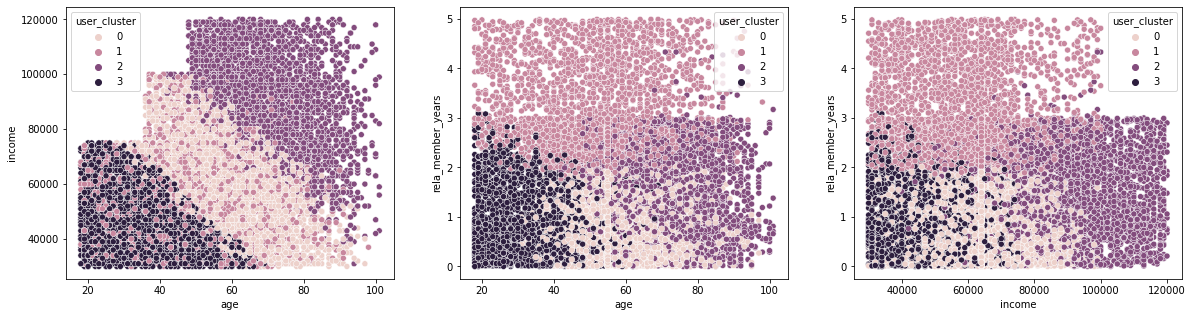

In [18]:
# Viewing by metrics

# Plot settings
f, ax = plt.subplots(ncols=3)
f.set_size_inches(20,5)

# Plot Age x Income x Time as Member
sns.scatterplot(data=profile, x='age', y='income', hue='user_cluster', ax=ax[0])
sns.scatterplot(data=profile, x='age', y='rela_member_years', hue='user_cluster', ax=ax[1])
sns.scatterplot(data=profile, x='income', y='rela_member_years', hue='user_cluster', ax=ax[2])

From the above viewer, these are the groups of users revealed by clustering

>**0: Middle age, middle income and recent member**  
>**1: Middle age, middle income and antique members**  
>**2: High age, high income and recent member**  
>**3: Low age, low income and recent member**     

#### Exporting dataset

In [19]:
# Exporting the user base with clusters
profile.to_csv('data_treated/profile_clustered.csv', index=False)